In [20]:
import jax
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.linalg import cho_factor, cho_solve
from functools import reduce
#from jax.scipy.optimize import minimize
#from jaxopt import ProjectedGradient
#from jaxopt.projection import projection_box

Summary of useful results of regression with sum of GPs

$$K = K_1 + \ldots + K_n$$
$$f_i \sim \mathcal{GP}(0, K_i), f:= \sum_j f_j$$
$\mathbb E[f_i|\sum_j f_j(X) = Y] = K_i(\cdot, X) K(X,X)^{-1} Y$, <br /> clearly $\mathbb E[f|f(X) = Y] = \sum_i  E[f_i|\sum_j f_j(X) = Y] = K(\cdot, X) K(X,X)^{-1} Y$ by linearity of expectation <br />
RKHS norm decomposition <br />
$\|ck(\cdot, X)\|_k = c^T k(X,X) c$, so $\|K(\cdot, X) K(X,X)^{-1} Y\|_K  = Y^T K(X,X)^{-1} Y$ and $\|K_i(\cdot, X) K(X,X)^{-1} Y\|_{K_i}  = Y^T K(X,X)^{-1} K_i(X,X) K(X,X)^{-1} Y$, so that clearly 
$$\sum_i \|K_i(\cdot, X) K(X,X)^{-1} Y\|_{K_i} = \|K(\cdot, X) K(X,X)^{-1} Y\|_{K}$$ 

In [2]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

@jit
def k(v1, v2, a=1, sigma=1):
    d = dists(v1, v2)
    return a*(1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)


### 6.1 With two primary variables

In [3]:
def plot_energy_ratio(Xs, Ys):
    E_1s = []
    E_2s = []
    nuggets = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    for nugget in nuggets:
        #nugget = 1e-4
        Kxx = k(Xs,Xs)
        nuggeted_matrix = Kxx+nugget*np.eye(len(Kxx))
        
        #test_x = np.linspace(-2,2,200)
        #K_te_tr = k(test_x, x1s)
        #conditional_mean = K_te_tr@np.linalg.solve(nuggeted_matrix, x2s)
        
        #Energy ratio
        v = np.linalg.solve(nuggeted_matrix, Ys) #v1 = K(X,X)^-1 Y
        E_1 = v.T @ Kxx @ v #E_i = Y^T K(X,X)^-1 K_i(X,X) K(X,X)^-1 Y 
        E_2 = v.T @ np.eye(len(Kxx))*nugget @ v
        E_1s.append(E_1)
        E_2s.append(E_2)
        #print(nugget, E_1/E_2)

    E_1s = np.array(E_1s)
    E_2s = np.array(E_2s)
    plt.plot(nuggets, E_1s/(E_1s + E_2s), label = 'Signal RKHS norm')
    plt.plot(nuggets, E_2s/(E_1s + E_2s), label ='Noise RKHS norm')
    plt.xscale('log')
    plt.vlines(1e-1, 0, 1, label = 'True noise', color = 'red')
    plt.xlabel(r'$\sigma^2$')
    plt.legend()


In [4]:
x1s = np.linspace(-2, 2, 100)
x2s = x1s**2 + 1 + onp.random.random(size = len(x1s))*1e-1

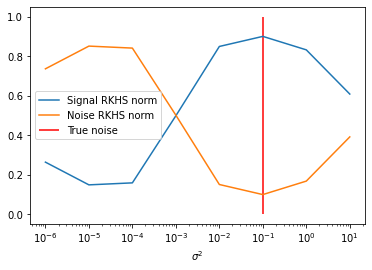

In [5]:
plot_energy_ratio(Xs=x1s, Ys =x2s)

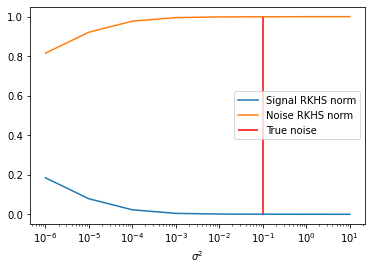

In [6]:
plot_energy_ratio(Xs=x2s, Ys = x1s)

In [7]:
x1s = np.linspace(-2, 2, 100)
x2s = x1s + onp.random.random(size = len(x1s))*1e-1

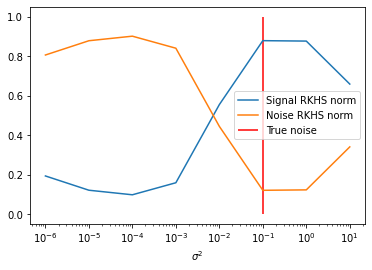

In [8]:
plot_energy_ratio(Xs=x1s, Ys =x2s)

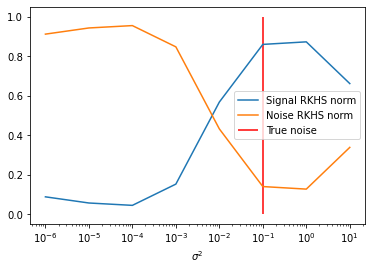

In [9]:
plot_energy_ratio(Xs=x2s, Ys = x1s)

In [10]:
x1s = onp.random.random(size = 100)*1e-1
x2s = onp.random.random(size = 100)*1e-1

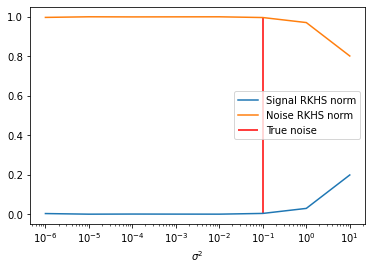

In [11]:
plot_energy_ratio(Xs=x1s, Ys =x2s)

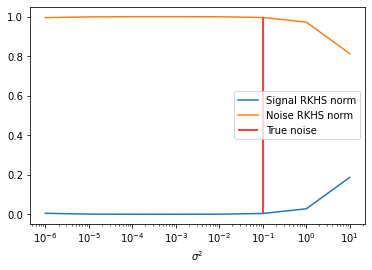

In [12]:
plot_energy_ratio(Xs=x2s, Ys = x1s)

### 6.2 With three primary variables

In [17]:
#Need to define one kernel for each node
#Here we take matern for all
def k(v1, v2, a=1, sigma=1):
    d = dists(v1, v2)
    return a*(1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
ks = [k]*3

In [21]:
def build_graph(X, ks, nugget, γ1 = 0.5, γ2 = 0.6, verbose = True, names = None):
#nugget = σ^2 = noise level
#γ1 = threshold between signal energy and noise energy to decide to explore ancestors
#γ2 = threshold between energies to decide to prune an ancestor
    N_nodes = len(X)
    if names is None:
        names = range(N_nodes)
    Final_ancestors = {}
    for i in range(N_nodes):
        #Xs = np.vstack([X[j] for j in range(N_nodes) if j != i]).T
        the_others = [j for j in range(N_nodes) if j != i]
        Ys = X[i]
        Ms = {}
        for j in the_others:
            Ms[j] = 1 + ks[j](X[j], X[j])

        Kxx = reduce(np.multiply,list(Ms.values()))
        nuggeted_matrix = Kxx+nugget*np.eye(len(Kxx)) #Kxx
        v = np.linalg.solve(nuggeted_matrix, Ys) #v1 = K(X,X)^-1 Y
        E_1 = v.T @ Kxx @ v #E_i = Y^T K(X,X)^-1 K_i(X,X) K(X,X)^-1 Y 
        E_2 = v.T @ np.eye(len(Kxx))*nugget @ v
        if verbose: print('Node {0}, E_Signal = {1}, E_Noise = {2}'.format(names[i], E_1, E_2))

        if E_1 < γ1*(E_2+E_1):
            if verbose: print('Node {0} does not have any ancestors'.format(names[i]))
        if E_1 > γ1*(E_2+E_1):
            if verbose: print('Node {0} has ancestors'.format(i))

            ancestors = the_others.copy()
            for j in the_others:
                Maux = np.divide(Kxx, Ms[j])
                E1j = v.T @ Maux @ v
                E2j = v.T @ np.multiply(Maux,(Ms[j]-1))@v
                #Actually E2j is just E_1 - E_1j, but this is here for debugging/understanding purposes
                if verbose: print('Decomposing E_signal = {0} in without {1} = {2} and with {1} = {3}'.format(E_1, names[j], E1j, E2j))
                if E1j > γ2*(E2j+E1j):
                    ancestors.remove(j)

            if verbose: print('Node {0} has the ancestors {1}'.format(names[i], [names[k] for k in ancestors])) 
            Final_ancestors[i] = ancestors
    #print('---')
    #print('Final graph recovered')
    #print(Final_ancestors)
    return Final_ancestors

In [22]:
#What we expect to recover is X1-> X2 -> X3
x1s = np.linspace(-2, 2, 100)
x2s = x1s**2 + 1 + onp.random.random(size = len(x1s))*1e-1
x3s = x2s**2 - 1 + onp.random.random(size = len(x1s))*1e-1

X = [x1s, x2s, x3s]

In [23]:
print(build_graph(X, ks, nugget=1e-1, verbose=False))

{1: [0], 2: [1]}


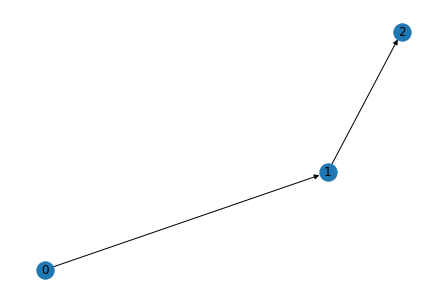

In [24]:
import networkx as nx

g = nx.DiGraph(build_graph(X, ks, nugget=1e-1, verbose=False)).reverse()
nx.draw(g, with_labels = True)

In [25]:
x1s = np.linspace(-2, 2, 100)
x2s = onp.random.random(100)
x3s = (x1s + x2s)**2 + onp.random.normal()*1e-1
X = [x1s, x2s, x3s]
build_graph(X, ks, nugget=1e-1)

Node 0, E_Signal = 30.24453158666713, E_Noise = 452.6834296696176
Node 0 does not have any ancestors
Node 1, E_Signal = 5.809892957722223, E_Noise = 11.571551368682481
Node 1 does not have any ancestors
Node 2, E_Signal = 36.39877480412856, E_Noise = 4.724359309348583
Node 2 has ancestors
Decomposing E_signal = 36.39877480412856 in without 0 = 3.879225036776972 and with 0 = 32.51954976735159
Decomposing E_signal = 36.39877480412856 in without 1 = 9.817961989596983 and with 1 = 26.58081281453159
Node 2 has the ancestors [0, 1]


{2: [0, 1]}

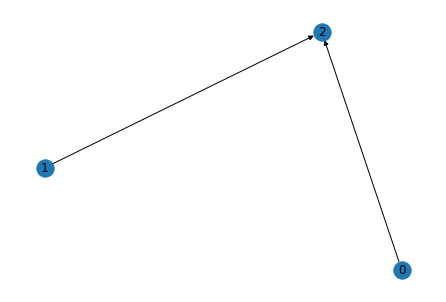

In [26]:
import networkx as nx

g = nx.DiGraph(build_graph(X, ks, nugget=1e-1, verbose=False)).reverse()
nx.draw(g, with_labels = True)

In [36]:
#Chemistry

\begin{equation}\label{eqehyehdyd}
\begin{split}
\frac{d[H_2]}{dt}&=-k_1[H_2]+k_{-1}[H]^2\\
\frac{d[H]}{dt}&=2k_1[H_2]-2k_{-1}[H]^2-k_2 [C_2H_4][H]-k_3[C_2H_5][H]\\
\frac{d[C_2H_4]}{dt}&=-k_2 [C_2H_4][H]\\
\frac{d[C_2H_5]}{dt}&=k_2 [C_2H_4][H]-k_3[C_2H_5][H]
\end{split}
\end{equation}

In [39]:
#From now on, we order them as (t, H2, H, C2H4, C2H5)

In [40]:
#Simulate data

In [41]:
from scipy.integrate import solve_ivp

In [90]:
def F(t, X): #all k = 1
    H_2, H, C2H4, C2H5 = X
    u = - H_2 + H**2
    d = 2*H_2 - 2*H**2 - C2H4*H - C2H5*H 
    t = -C2H4*H
    q = C2H4*H - C2H5*H
    return u, d, t, q

In [104]:
sol = solve_ivp(F,(0,10), [1,0,2,0], t_eval = np.linspace(0, 10, 250))

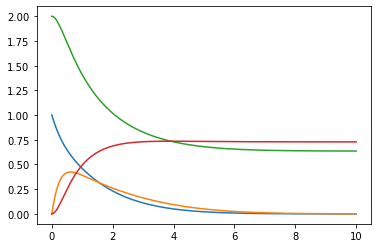

In [105]:
plt.plot(sol.t, sol.y.T)

In [107]:
X = np.hstack((sol.t.reshape(250,1), sol.y.T)).T

In [108]:
mapping = {
    0: 't',
    1: 'H2', 
    2:  'H',
    3: 'C2H4', 
    4: 'C2H5', 
}

In [109]:
from seaborn import pairplot
import pandas as pd

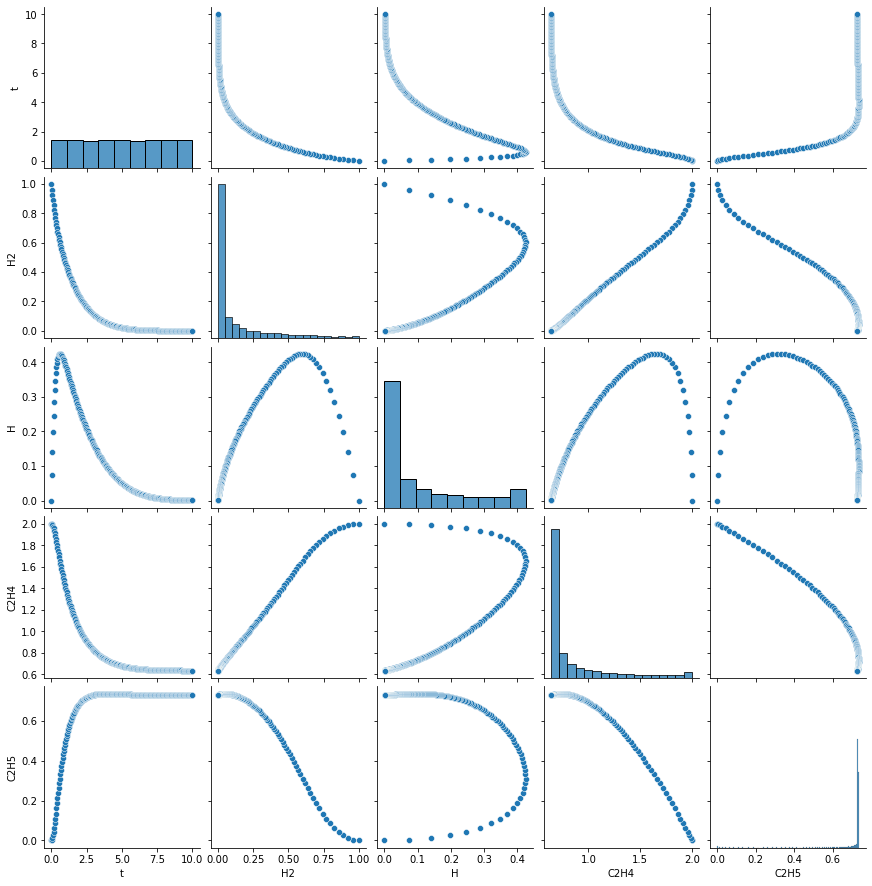

In [110]:
pairplot(pd.DataFrame(X.T, columns=mapping.values()))

Node t, E_Signal = 35131896.88678213, E_Noise = 60370056.13833889
Node t does not have any ancestors
Node H2, E_Signal = 0.08827091145505479, E_Noise = 3.8800805560098775e-07
Node 1 has ancestors
Decomposing E_signal = 0.08827091145505479 in without t = 0.035205202222377566 and with t = 0.053065709232719506
Decomposing E_signal = 0.08827091145505479 in without H = 0.03841890849064022 and with H = 0.04985200296442698
Decomposing E_signal = 0.08827091145505479 in without C2H4 = 0.03942662647540321 and with C2H4 = 0.048844284979643375
Decomposing E_signal = 0.08827091145505479 in without C2H5 = 0.04273814612974416 and with C2H5 = 0.045532765325328725
Node H2 has the ancestors ['t', 'H', 'C2H4', 'C2H5']
Node H, E_Signal = 0.1751081777169773, E_Noise = 1.1045603509526626e-05
Node 2 has ancestors
Decomposing E_signal = 0.1751081777169773 in without t = 0.04835752237176851 and with t = 0.1267506553432436
Decomposing E_signal = 0.1751081777169773 in without H2 = 0.04397994676805642 and with H2

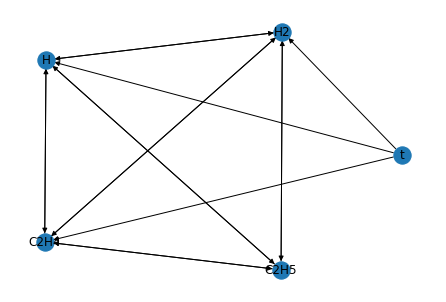

In [115]:
gg = build_graph(X, ks = [k]*len(X), γ2 = 0.6, nugget=1e-8, verbose=True, names = mapping)
g = nx.DiGraph(gg).reverse()
nx.relabel_nodes(g, mapping, copy = False)
nx.draw(g, pos = nx.layout.kamada_kawai_layout(g), with_labels = True)